# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: 

The first few PCA dimensions will be those that account for the highest proportion of variation in the output. We would expect them to be composed of original features that are correlated in some way: perhaps they are combinations of items that customers tend to purchase together, such as 'fresh' and 'grocery' products. The ICA dimensions will be dimensions that are independent of one another. It seems like 'delicatessen' and 'detergents_paper' are classes that would not be strongly correlated to other classes insofar as customer purchases are concerned, so they would likely show up as ICA dimensions. 

###PCA

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]

[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]

The principal components are orthonormal
The principal component matrix is orthogonal


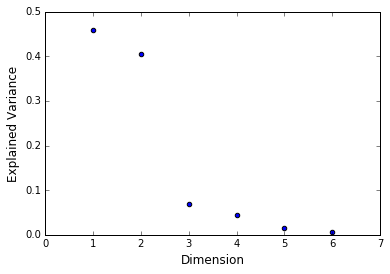

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
n = min(data.shape)
pca = PCA(n_components=n).fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print '\n', pca.explained_variance_ratio_

#plot data
plt.scatter(xrange(1,n+1), pca.explained_variance_ratio_)
plt.xlabel('Dimension', size=12)
plt.ylabel('Explained Variance', size=12)
plt.ylim(0)

# truth table from dot products between each row vector combo as check for orthonormality
# note the preparation for rounding errors
dot_matrix = [(0.99999999 < sum(pca.components_[i] * pca.components_[j]) < 1.00000001) if j==i #unit vector check
              else (abs(sum(pca.components_[i] * pca.components_[j])) < 1e-10) #orthogonality check
              for i in xrange(n)
              for j in xrange(i,n) ]
print '\nThe principal components are %sorthonormal' % (('not ', '')[all(dot_matrix)])

#another way to check for orthonormality of the principal component vectorsis the following: if the principal 
#components matrix is orthogonal, the principal component vectors within it must be orthonormal.
#A matrix is orthogonal if that matrix multiplied by its transpose equals the identity matrix. In other words, a 
#matrix whose transpose is also its inverse is orthogonal
U = np.matrix(pca.components_).T
truth_matrix = abs((U.T * U) - np.identity(n)) < np.full((n, n),1e-10)
print 'The principal component matrix is %sorthogonal' % (('not ', '')[truth_matrix.all()])

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

PCA orders its output in terms of explained variance, i.e. the fraction of variance in the data explained by the relationships encoded in each principal component. So we know that the first pricipal component explains more of the variance than any other, the second component more than any other but the first and so on down the line. In our example, the first two principal components account for 46.0% and 40.5% of the variance in the data respectively. In contrast, the third principal component accounts for only 7.0% of the variance. It is clear from the plot above that the explained variance drops off rapidly after the first two components.

These results suggest that a total of two principal component dimensions is the ideal number for our data. The first two dimensions explain almost 86.5% of the variance in the data set. Of course we could explain more of the variance by including additional dimensions, but then we run the risk of overfitting and the increase in model variance error that comes with it (variance here refers to the type of modelling error, rather than the distribution of the original data set that we had been discussing earlier). Having said that, the ideal number of two dimensions was arrived at be heuristic means, and the proper way to do it would be to train models with different numbers of dimensions, perhaps using the feature selection technique, then see how they perform on test data. Nevertheless, based only on the analysis at hand, we choose to work with two dimensions.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

The principal component dimensions represent vectors that are linear combinations of the original feature dimensions. In fact, the analysis above shows them to be mutually orthogonal unit vectors. We can think of the six principal component vectors as elements of a principal component matrix, which because the individual vectors within it are orthonormal is orthogonal. This matrix corresponds to a set of six-dimensional orthogonal axes rotated with respect to the original six-dimensional feature axes. The principal components matrix can be applied to an input feature vector to project it onto the principal component axes. Now for our purposes it's not so interesting to take an input, rotate it around in six-dimensional space and see what it looks like when written in terms of a principal component system. But we can see how to extend the concept to execute the highly useful dimensionality reduction discussed in question 2. As opposed to a 6x6 principal component matrix that projects a 6-dimensonal feature vector onto a 6-dimensional principal component space, we can construct a 2x6 principal component matrix that projects a 6-dimensional feature vector onto a 2-dimensional principal component space. Provided this reduced dimensionality principal component space explains a sufficient amount of the variance in the data (which by the analysis above, we know ours does) we can substantially reduce the computational workload a clustering algorithm would be asked to perform without sacrificing much in terms of valuable information. 

The first principal component dimension has a coefficient of -0.98 for the 'fresh' feature, -0.15 for the 'frozen' feature and so on. It's pretty obvious that the first principal component is predominantly the 'fresh' feature vector rotated a bit away from the original. Despite the answer given to question 1 above, it seems like the 'fresh' feature has become a principle component almost unto itself. And now that we see this, we see the error in our ways that led to the erroneous answer to question 1. There is no reason that the most principal component need elucidate a strong covariance relationship between features. According to the README doc, the 'fresh' feature has the largest variance of any feature, and we attribute this, at least in part, to scale: the shops spend 50% more on average on 'fresh' items than on those from any other category. There is no need for 'fresh' to correlate to any other feature to have a great influence on total variance. There just needs to be a lot of variation from shop to shop on how much they spend on 'fresh' items. We can use this finding to suggest our wholesale distributor client increase marketing on 'fresh' products to shops who don't buy much of it, as there seems to be a great but uneven demand for 'fresh' products across the client's customer base.

The second dimension shows what appears to be the type of correlation we initially expected to see, between two or even three of the original features: 'grocery' with coefficient 0.76, 'milk' with coefficient 0.52 and perhaps 'detergents_paper' with coefficient 0.37. This component is much more a composite of multiple features than the first principal component. This is an interesting finding, as it tells us that stores that buy more 'grocery' items tend also to buy more 'milk' items and to some degree more 'detergents_paper' items as well (and they do correlate positively: all coefficients are the same sign: positive). We can use this discovery to encourage our wholesale distributor client to try to increase sales by marketing these items in a synergistic fashion, and to reduce costs by bundling/delivering them together.

###ICA

In [3]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first! <-- this is done automatically during whitening
from sklearn.decomposition import FastICA
n = min(data.shape)
ica = FastICA(n_components=n, random_state=42).fit(data)

# Print the independent components
print ica.components_

#check to see if IC matrix is orthogonal
W = np.matrix(ica.components_)
truth_matrix = abs((W.T * W) - np.identity(n)) < np.full((n, n),1e-10)
print '\nThe independent component matrix is %sorthogonal' % (('not ', '')[truth_matrix.all()])

#check to see if IC's are unit vectors
square_matrix = [(0.99999999 < sum(ica.components_[i] * ica.components_[i]) < 1.00000001) 
              for i in xrange(n) ]
print 'The independent components are %sunit vectors' % (('not ', '')[all(square_matrix)])

#check to see if IC's are orthogonal
cross_matrix =  [(abs(sum(ica.components_[i] * ica.components_[j])) < 1e-10) #orthogonality check
              for i in xrange(n)
              for j in xrange(i+1,n)]
print 'The independent components are %sorthogonal' % (('not ', '')[all(cross_matrix)])

[[  8.65203357e-07   1.40433954e-07  -7.74134859e-07  -1.11461596e-05
    5.55175206e-07   5.95231239e-06]
 [ -3.97590618e-06   8.59058328e-07   6.24232403e-07   6.77446468e-07
   -2.06101033e-06   1.04342316e-06]
 [ -2.10589800e-07   1.88727663e-06  -6.41843645e-06  -4.12230621e-07
    7.88586022e-07   1.45013212e-06]
 [  3.86436469e-07   2.19531902e-07   6.00815003e-07   5.22057330e-07
   -5.10239101e-07  -1.80925706e-05]
 [  1.53632693e-07   9.84534859e-06  -5.80984571e-06  -3.63864019e-07
    3.31536850e-06  -6.05749699e-06]
 [ -2.99843192e-07   2.30595406e-06   1.20636760e-05  -1.46257243e-06
   -2.82071883e-05  -5.73219911e-06]]

The independent component matrix is not orthogonal
The independent components are not unit vectors
The independent components are not orthogonal


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

Contrary to the principal components matrix, the independent components matrix is composed of vectors that are neither of unit length nor mutually orthogonal. The fact that that the independent component vectors are not orthogonal is a direct result of our attempt to make them independent. The fact  they have different lengths suggests that the length of an independent component vector has some meaning. But it is not clear at the present time just what this meaning is.

In any case, we can get some idea of what groups of products trend together be looking at the coefficients inside each independent component vector. Within a vector, the magnitude of a coefficient tells us how important the feature to which it corresponds is to that independent component vector. By focusing on the coefficients of greatest magnitude within a vector, we can get an idea of how customers purchase products from different feature groups. If two coefficients have the same sign this implies that sales of the feature items to which they correspond trend together. If they have opposite sign, it implies that customers who buy more from one group buy less from the other. We can utilize this knowledge to better assist our wholesale distributor client optimize marketing strategies to increase sales, perhaps by offering discounts on purchases of one feature group item based on the purchase of another form a different but synergistic feature group. We can also suggest ways to maximize efficiency and cost reduction by bundling delivery of feature items that scale together.

The first independent component on the list is composed of something like 2 parts 'frozen', 1 part 'delicatessen' and smaller bits of the other features. Because the coefficients have opposite sign, we see that stores that buy more 'frozen' goods buy less 'delicatessen' goods and vice versa.

The second independent component on the list is composed of something like 4 parts 'fresh', 2 parts 'detergents_paper', 1 part 'delicatessen' and smaller bits of the other features. Again because the coefficients, we see that 'fresh' and 'detergents_paper' trend together, whereas 'delicatessen' purchases go down as the others go up.

The third independent component on the list is composed of something like 6 parts 'grocery', 2 parts 'milk', 1 part 'delicatessen' and smaller bits of the other features. We see that 'grocery' trends against 'milk' and 'delicatessen'.

The fourth independent component on the list is composed of almost entirely 'delicatessen'. 'Delicatessen seems to play an important role in all of the independent components, doesn't it? That might imply that we could segment our customer base into different groups based on how they purchase 'delicatessen' items in relation to other stuff.

The fifth independent component on the list is a mixture of a lot of stuff: 10 parts 'milk', 6 parts 'grocery', 6 parts 'delicatessen', 6 parts 'delicatessen', 3 paers 'detergents_paper' and smaller bits of the remaining features. 'Milk' and 'detergents_paper' trend together, as do 'grocery' and 'delicatessen', which of course implies they trend opposite the other two.

The sixth independent component on the list is composed of something like 6 parts 'detergents_paper', 2 parts 'grocery', 1 part 'delicatessen' and smaller bits of the other features. 'Detergents_paper' trends with 'delicatessen' and against 'grocery'.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

[K Means clustering](http://scikit-learn.org/stable/modules/clustering.html#k-means) is a quick and conceptually straightforward algorithm for clustering data. It works well when the data clusters are relatively simple in shape, like Gaussian hyperspheres, but can struggle to identify clusters properly when the clusters have more complex non-linear geometries.

[Gaussian Mixture Models](http://scikit-learn.org/stable/modules/mixture.html) is an generalization of K Means clustering that takes into account the covariance of the data. It os very fast, and it does not presume the data has a specific structure that may in fact not be applicable.

Gaussian Mixture Models is a better choice, simply because it presumes less than K Means Clustering about the structure of the data. So this is the model that we will use.

Notice that both of these models presume more or less that the data are Gaussian distributed. This is at odds with the Independent Components Analysis, which presumes that the data are certainly not Gaussian distributed. For this reason, we will not be using ICA for preprocessing. We will use PCA instead.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [4]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [5]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
PCMatrix = PCA(n_components=2).fit(data).components_
reduced_data = np.dot(data, PCMatrix.T)
print reduced_data[:10]  # print up to 10 elements

[[-14112.07286824  10409.72068096]
 [ -9035.2457668   12866.65309972]
 [ -8620.05203937  11402.96376688]
 [-14452.39718306   2544.39559425]
 [-24120.04947733   6664.4757757 ]
 [-10696.08915346   7864.33086375]
 [-12746.49985397   6811.19932521]
 [ -8987.4670792   10253.69856292]
 [ -6749.95534899   6618.2924349 ]
 [ -8638.4163921   22304.76079577]]


In [6]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
# find best-performing gmm model using an ad-hoc grid-search approach with BIC as metric
# adapted from 
# http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#example-mixture-plot-gmm-selection-py
lowest_BIC = np.infty
for n_components in xrange(1,11):
    for covariance_type in ('spherical', 'tied', 'diag', 'full'):
        gmm = GMM(n_components, covariance_type, random_state=42)
        this_clustering = gmm.fit(reduced_data)
        this_BIC = gmm.bic(reduced_data)
        if this_BIC < lowest_BIC:
            lowest_BIC, clusters = this_BIC, gmm

print clusters.fit(reduced_data)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=8, n_init=1, n_iter=100, params='wmc', random_state=42,
  thresh=None, tol=0.001, verbose=0)


In [7]:
# identify which customers are in which cluster
x = data['Cluster'] = clusters.predict(reduced_data)

# print cluster sample counts and averages
for i in xrange(clusters.n_components):
    count = data[x==i].shape[0]
    print 'There %s %s sample%s in Cluster %s' % (('is', 'are')[count>1], count, ('', 's')[count>1], i)
    print 'Here is what %s Cluster %s customer%s buys from the wholesale distributor:' % (
        ('the', 'a typical')[count>1], i, ('','s')[count>1])
    print data[x==i][list(data.columns[:-1])].mean(),'\n'

There are 83 samples in Cluster 0
Here is what a typical Cluster 0 customers buys from the wholesale distributor:
Fresh                2149.674699
Milk                 7534.144578
Grocery             12095.048193
Frozen               1297.361446
Detergents_Paper     5258.325301
Delicatessen         1244.012048
dtype: float64 

There are 122 samples in Cluster 1
Here is what a typical Cluster 1 customers buys from the wholesale distributor:
Fresh               12426.024590
Milk                 1572.221311
Grocery              1984.680328
Frozen               3645.377049
Detergents_Paper      340.131148
Delicatessen          801.868852
dtype: float64 

There are 77 samples in Cluster 2
Here is what a typical Cluster 2 customers buys from the wholesale distributor:
Fresh               18608.415584
Milk                 6437.207792
Grocery              8283.792208
Frozen               3945.909091
Detergents_Paper     2191.766234
Delicatessen         2110.493506
dtype: float64 

There are 9 

In [8]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [9]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 
centroids = clusters.means_
print centroids

[[  -4058.55883796   14247.16721981]
 [ -13007.08613801    1162.68366073]
 [ -19022.98339065    7791.09810257]
 [ -33154.02804526   54512.9623942 ]
 [ -39822.67630219     411.02519907]
 [-117325.47606621   18734.55121945]
 [  -5925.19361093    3552.54609579]
 [ -10690.43525617   23789.07516358]]


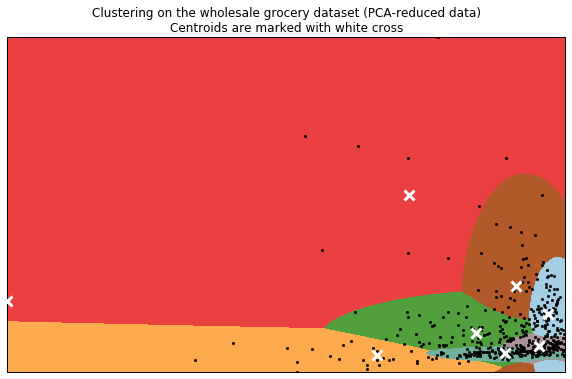

In [10]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1,figsize=(10,6))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=100, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

The graph above shows the customer data plotted in terms of the first principal component along the x-axis and the second principal component along the y-axis. The various colors represent the optimal clusterings.

Recall from question 2 that the first principal component is predominantly the negative of the 'fresh' category, and that the second principal component is an amalgamation of 'grocery', 'milk' and a bit of 'detergents_paper' (hereafter known as 'GMDP'), all positive. Since the x-axis shows negative values, the larger magnitudes are to the left.

The number of clusters was determined by an ad-hoc grid search using Bayesian Information Criteria (BIC) above, Details of the clusters, including sample size and average purchases by product group were provided earlier. Here we discuss them in terms of the plot immediately above, and introduce a bit of conjecture as to what type of businesses these customers might be.

Cluster 0: the small customers that buy mostly 'GMDP' and don't buy much 'Fresh' or other products, shown in the graph as a vertical sky blue oval in the lower right. These might be convenience stores and corner markets.

Cluster 1: the small customers that buy mostly 'Fresh' and don't buy much 'GMDP' or other products, shown in the graph as a long and narrow bluish green horizontal oval in the lower right. These might be delis and single-outlet fast food shops.

Cluster 2: the mid-sized customers that buy mostly 'Fresh' but also buy a good amount of 'GMDP' and other products, shown in the graph as the large greenish spearhead shape. These might be larger restaurants.

Cluster 3: the customers who tend to buy lots of both 'fresh' and 'GMDP', whose area takes up most of the diagram and is shown in red. These customers might be big-box retailers who sell a wide variety of products in bulk.

Cluster 4: the large customers who tend to buy mostly 'fresh' products, shown along the bottom toward the left in orange. These might be cafeterias belonging to large corporations, schools or the government (military bases, prisons, etc.).

Cluster 5: a singe customer that buys a huge amount of 'Fresh' products. It does not have a corresponding area on the color map, but is represented by the white cross at the extreme left. It might a regional distribution center for a national fast food chain.

Cluster 6: the small customers that buy mostly 'Fresh' as well as a decent amount of 'GMDP' or other products, shown in the graph as the lavender spearhead shape in the lower right. These might be delis and single-outlet fast food shops, similar to Cluster 1 customers but perhaps serving different neighborhoods or customer bases.

Cluster 7: the mid sized customers that tend to buy predominantly 'GMDP' products, shown as the occluded brown semi-egg at right. These might be mid sized single-outlet grocery stores.

###Conclusions

**8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

It seems that the Gaussian Mixture Model helped a lot to make sense out of the data. It tended to identify customer groups that lent themselves to easy (and hopefully correct) interpretation. We suspect it has done a better job at elucidating these details then K Means would, as we would not expect K Means to identify the long and narrow clusters that are nicely picked out by the Gaussian Mixture Model. Of course, all this was enabled by PCA which did an excellent job of collapsing six dimensions of data down to a convenient but still highly informative two. 

**9)** How would you use that technique to help the company design new experiments?

Answer: 

The original problem that our wholesale distributor client has was that when they adjusted their delivery schedule, smallee customers like those in Groups 1 and 4 complained that it did not suit their schedule. But these complaints did not register during the trial phase of the new delivery system, presumably because our client focused on the larger customers, like those in Groups 3 and 6, who had no issue with the new delivery system.

Now that we have demonstrated a method of categorizing our client's customers based on what they purchase and how much of it, we can propose modifications and improvements to our client's delivery and marketing strategies that are tailored to a customer group. For example, while a low-cost bulk nightly delivery schedule was not acceptable to our customer's smaller clients, we could propose experiments to identify reduced cost delivery methods that would be acceptable to these customery, perhaps a bulk delivery system in the early business hours. We could also run some marketing experiments, like offering discounts on 'milk' products to customers who buy a lot of 'grocery' products to leverage product synergies and increase overall sales.

**10)** How would you use that data to help you predict future customer needs?

Answer: 

We could track product group purchases over time by customer group, for which we could use the supervised learning technique of regression. For example, perhaps we would uncover a trend that suggests sales of 'frozen' products are decreasing over time in favor of 'fresh' products. We could alert our wholesale distributor to this trend in advance such that they could proactively prepare for a shift in customer demand. We could look deeply into the data to see if this was a universal trend, or if it affected only a subset of customer groups.